In [1]:
import numpy as np
from typing import Optional, Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
from scipy.fftpack import fft, ifft, fftshift
from scipy.signal import find_peaks
from ipywidgets import interact, FloatSlider
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib widget

# Exercise 6: **Signal Mixing**

*Visualize and explain the functionality of a coherent measurement system. You should be able to
visualize all input-, intermediate-, and output signal components (LO, RF, IF, I- and Q-channel).
You can use a unit amplitude for simplicity.*

Let's assume the antenna output signal $S_{RF}$ is given as a simple harmonic:

$S_{RF} = A_{RF} \cdot \cos\left(\omega_{RF}t\right)$

Both the amplitude $A_{RF}$ and the angular frequency $\omega_{RF}$ are unknown. The goal is to determine these two parameters.

To do so, the antenna output signal is mixed with a local oscillator (LO) signal $S_{LO}$, which is given as a simple harmonic:

$S_{LO} = A_{LO} \cdot \cos\left(\omega_{LO}t\right)$

The LO signal is generated by a local oscillator, which is a device that generates a sinusoidal signal with a known amplitude $A_{LO}$ and angular frequency $\omega_{LO}$. The frequency of the LO signal is chosen such that it is close to the frequency of the antenna output signal, i.e. $\omega_{LO} \approx \omega_{RF}$. The LO signal is then mixed with the antenna output signal in a mixer. 

The mixer is a device that multiplies the two input signals and outputs the product of the two input signals. The output signal of the mixer is given as:

$S_{M} = A_{RF} \cdot A_{LO} \cdot \cos\left(\omega_{RF}t\right) \cdot \cos\left(\omega_{LO}t\right)$

Using the trigonometric identity $\cos\left(\alpha\right)\cos\left(\beta\right) = \dfrac{1}{2}\left(\cos\left(\alpha + \beta\right) + \cos\left(\alpha - \beta\right)\right)$, the output signal of the mixer can be rewritten as:

$S_{M} = \dfrac{A_{RF} \cdot A_{LO}}{2} \cdot \left(\cos\left(\left(\omega_{RF} + \omega_{LO}\right)t\right) + \cos\left(\left(\omega_{RF} - \omega_{LO}\right)t\right)\right)$

The output signal of the mixer thus consists of two components, one with the sum of the two input frequencies and one with the difference of the two input frequencies. The component with the sum of the two input frequencies is filtered out by a low-pass filter, which only allows signals with frequencies below a certain threshold to pass. The component with the difference of the two input frequencies is the intermediate frequency (IF) signal. The IF signal is given as:

$S_{IF} = \dfrac{A_{RF} \cdot A_{LO}}{2} \cdot \cos\left(\left(\omega_{RF} - \omega_{LO}\right)t\right)$

To obtain information aboyt both the phase and amplitude of the emw detected by the antenna, coherent measurement system takes the IF signal and splits it into two components, the in-phase (I) and quadrature (Q) components.
In order to do so, the local oscillator (or stable local oscillator) is coupled to a coherent local oscillator (CLO), which is a device that generates a sinusoidal signal with the same amplitude $A_{LO}$, angular frequency $\omega_{LO}$ and phase $\phi_{LO}$ as the LO signal. The CLO signal is then mixed with the IF signal in a mixer. The output signal of the mixer is given as: 

The I and Q components are given as:  

$S_I = \dfrac{A_{RF} \cdot A_{LO}}{2} \cdot \cos\left(\left(\omega_{RF} - \omega_{LO}\right)t\right) \cdot \cos\left(\omega_{LO}t\right) = \dfrac{A_{RF} \cdot A_{LO}}{4} \cdot \left(\cos\left(\left(\omega_{RF} - 2\omega_{LO}\right)t\right) + \cos\left(\left(\omega_{RF} - \omega_{LO}\right)t\right)\right)$

$S_Q = \dfrac{A_{RF} \cdot A_{LO}}{2} \cdot \cos\left(\left(\omega_{RF} - \omega_{LO}\right)t\right) \cdot \sin\left(\omega_{LO}t\right) = \dfrac{A_{RF} \cdot A_{LO}}{4} \cdot \left(\sin\left(\left(\omega_{RF} - 2\omega_{LO}\right)t\right) - \sin\left(\left(\omega_{RF} - \omega_{LO}\right)t\right)\right)$

The I and Q components are then low-pass filtered to remove the component with the sum of the two input frequencies. The resulting I and Q components are then sampled and digitized. The resulting digital signal is then processed by a computer to obtain information about the phase and amplitude of the emw detected by the antenna.


## 6.1 How does the mixed signal change in response to the frequency diﬀerence of the input signals?

As stated above, the mixed signal consists of two components: a high and a low freequency component. While the high frequency component depends on the sum of the RF and LO frequencies, the low frequency component depends on the difference of the RF and LO frequencies. Increasing $\Delta (\omega_{RF}, \omega_{LO})$ from zero (i.e. decreasing $\omega_{LO}$ to zero) decreases the high frequency component and increases the low frequency component of the mixed signal. In general, the high frequency component 'follows the course of the low frequency component'.

* $\omega_{LO} = \omega_{RF}$: The low frequency component is a constant, with $y = \dfrac{A_{RF} \cdot A_{LO}}{2}$. Thus, $S_{M}$ has double the frequency of $S_{RF}$ and an amplitude of $\dfrac{A_{RF} \cdot A_{LO}}{2}$, but is shifted on the $y$-axis by $\dfrac{A_{RF} \cdot A_{LO}}{2}$, because it follows the constant course of the low frequency component
* $0 < \omega_{LO} < \omega_{RF}$: the low frequency component no longer is a constant, but a harmonic, too. Thus, the high frequency component follows the oscillation of the low frequency component.
* $\omega_{LO} = 0$: The frequencies of both the low and high frequency components are identical, as are their amplitudes. The amplitude is again given as $\dfrac{A_{RF} \cdot A_{LO}}{2}$.

## 6.2 How can you synthesize the ﬁlter in your code using a simple mathematical operation (given the knowledge of the amplitude and the frequency of the signals)?

Neither the frequency nor the amplitude of the RF signal are known, only those of the LO signal. A simple approach to obtain the IF signal, which contains the information about the RF and the LO signal, is to use a low-pass filter. The low-pass filter only allows signals with frequencies below a certain threshold to pass. To realize this, the following recipe is used, based on a simple Fourier filter:

1. Compute the Fourier transform of the mixed signal $S_{M} = S_{RF}\cdot S_{LO}$ in the frequency domain
2. Chose the cutoff frequency (e.g. by looking at the power spectrum of the mixed signal)
3. Set all frequencies above $\omega_{cutoff}$ to zero
4. Compute the inverse Fourier transform of the filtered signal to obtain $S_{IF}$ in the time domain

In [2]:
def harmonic_generator(freq: float, t: float, amplitude: Optional[float] = 1, phase: Optional[float] = 0, offset: Optional[float] = 0) -> float:
    '''Generates a harmonic signal with a given angular frequency, amplitude and time.
    
    Parameters:
    -----------
    freq: float
        Frequency in 1/s
    t: float
        Time in s
    amplitude: float, optional
        Amplitude of the harmonic signal, default is 1
    phase: float, optional
        Phase of the harmonic signal in rad, default is 0
    offset: float, optional
        Offset of the harmonic signal, default is 0
        
    Returns:
    --------
    float
        Harmonic signal'''
    
    return amplitude * np.cos(2*np.pi*freq * t + phase) + offset


def freq_differ(freq: float, percentage: float = 0.05) -> float:
    '''Calculates the frequency difference of a given frequency and a percentage.
    
    Parameters:
    -----------
    freq: float
        Frequency in Hz
    percentage: float
        Frequency difference in percentage [0.0, 1.0], default is 0.05
        
    Returns:
    --------
    float
        Frequency in Hz
    '''
    
    return freq * (1 - percentage)


def fourier_low_pass(input_signal: np.array, fs: float, cutoff_frequency: Optional[float] = None) -> np.array:
    '''Applies a low pass filter to a given signal using the Fourier transform.
    
    Parameters:
    -----------
    
    input_signal: np.array
        Input signal
    fs: float
        Sampling frequency
    cutoff_frequency: float, optional
        Cutoff frequency in Hz, default is None (cutoff frequency is automatically set to the mean of the peaks of the power spectrum)
        
    Returns:
    --------
    np.array
        Filtered signal
    '''


    input_signal_fft = fft(input_signal)
    freq = np.fft.fftfreq(len(input_signal), 1/fs)

    # if cutoff_frequency is None, the cutoff frequency is set to the mean of the peaks of the power spectrum
    # by doing so, the cutoff frequency is automatically adjusted to the signal
    if not cutoff_frequency:
        peaks, _ = find_peaks(np.abs(input_signal_fft))
        cutoff_frequency = np.mean(np.abs(freq[peaks]))

    # creare a frequency filter
    frequency_filter = np.zeros_like(freq)
    frequency_filter[np.abs(freq) <= cutoff_frequency] = 1

    filtered_signal_fft = input_signal_fft * frequency_filter
    filtered_signal = ifft(filtered_signal_fft)

    power_spectrum_original = np.abs(fftshift(input_signal_fft)) ** 2
    power_spectrum_filtered = np.abs(fftshift(filtered_signal_fft)) ** 2


    return filtered_signal, fftshift(freq), power_spectrum_original, power_spectrum_filtered


interactive(children=(FloatSlider(value=0.0, description='$\\Delta\\nu$', max=1.0, step=0.01), Output()), _dom…

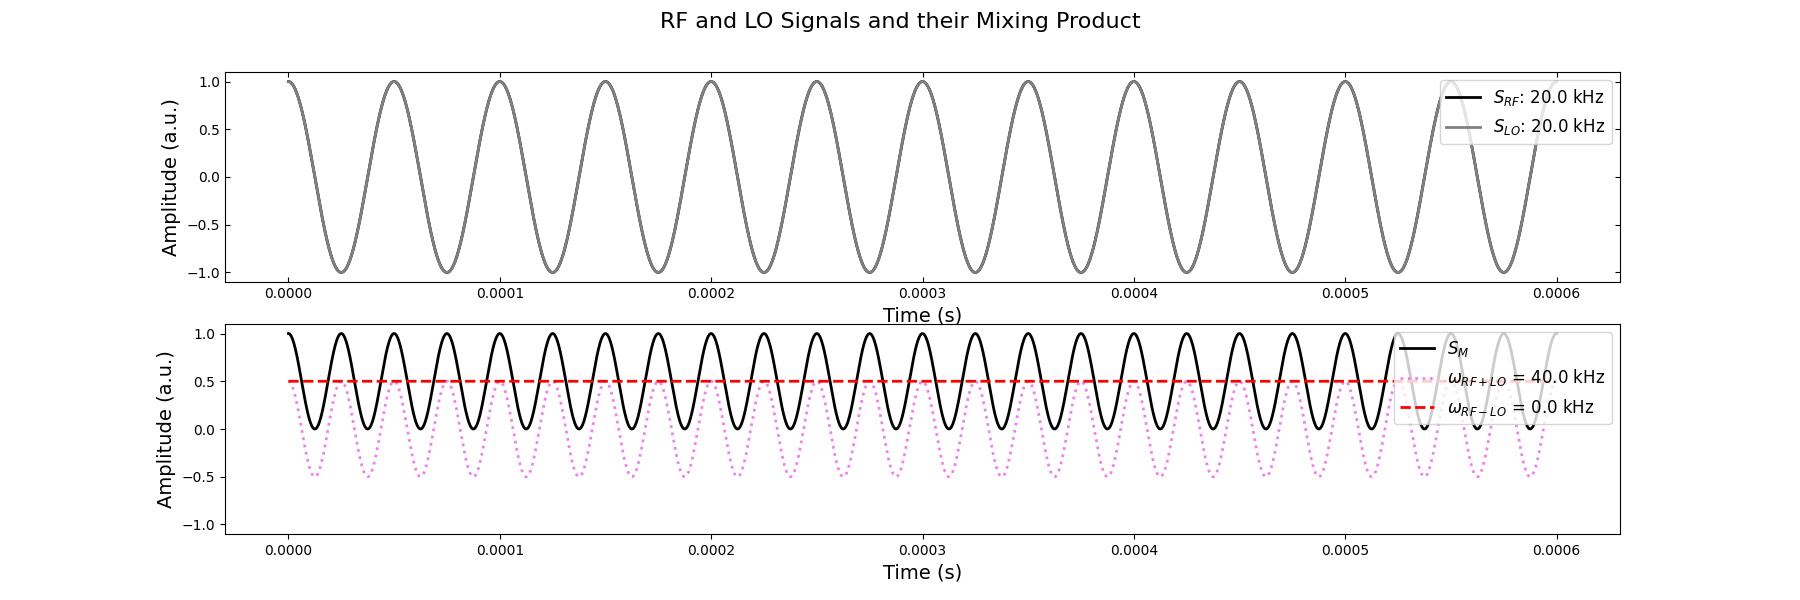

In [3]:
freq_rf = 20e3  # Hz
amplitude_rf = 1
amplitdue_lo = 1
diff = 0.1
fs = 10001 # sampling frequency
def get_time_arr(fs: int):
    return np.linspace(0, 12/freq_rf, fs)

t = get_time_arr(fs)

signal_rf = harmonic_generator(freq=freq_rf, t=t, amplitude=amplitude_rf)
signal_lo = harmonic_generator(freq=freq_differ(freq_rf, diff), t=t, amplitude=amplitdue_lo)

fig = plt.figure(figsize=(18, 6))
fig.suptitle(r'RF and LO Signals and their Mixing Product', fontsize = 16)
ax1 = fig.add_subplot(211)
ax1.tick_params(axis='both', which='both', direction = 'in', top=True, bottom=True, left=True, right=True)
l10, = ax1.plot(t, signal_rf, linewidth = 2, color = 'black', label = r'$S_{RF}$: ' + f'{(freq_rf/1000):.1f} kHz')
l11, = ax1.plot(t, signal_lo, linewidth = 2, color = 'grey', label = r'$S_{LO}$: ' + f'{(freq_differ(freq_rf, diff)/1000):.1f} kHz')

ax1.set_xlabel(r'Time (s)', fontsize = 14)
ax1.set_ylabel(r'Amplitude (a.u.)', fontsize = 14)
ax1.legend(loc = 'upper right', fontsize = 12)

ax2 = fig.add_subplot(212)
l20, = ax2.plot(t, signal_rf * signal_lo, linewidth = 2, color = 'black', label = r'$S_{M}$')

high_freq_comp = harmonic_generator(freq=freq_rf + freq_differ(freq_rf, diff), t=t, amplitude=amplitude_rf * amplitdue_lo / 2)
low_freq_comp = harmonic_generator(freq=freq_rf - freq_differ(freq_rf, diff), t=t, amplitude=amplitude_rf * amplitdue_lo / 2)
l21, = ax2.plot(t, high_freq_comp, linewidth = 2, color = 'violet', linestyle = 'dotted', label = r'$\omega_{RF + LO}$ = ' + f'{(freq_rf + freq_differ(freq_rf, diff))/1000:.1f} kHz')
l22, = ax2.plot(t, low_freq_comp, linewidth = 2, color = 'red', linestyle = 'dashed', label = r'$\omega_{RF - LO}$ = ' + f'{(freq_rf - freq_differ(freq_rf, diff))/1000:.1f} kHz')
ax2.set_xlabel(r'Time (s)', fontsize = 14)
ax2.set_ylabel(r'Amplitude (a.u.)', fontsize = 14)
ax2.legend(loc = 'upper left', fontsize = 12)

slider_freq_diff = FloatSlider(value=0.000, min=0.00, max=1.00, step=0.01, description=r"$\Delta\nu$")

@interact(diff = slider_freq_diff)
def update_plot(diff):
    updated_signal_lo = harmonic_generator(freq=freq_differ(freq_rf, diff), t=t, amplitude=1)
    updated_signal_if = signal_rf * updated_signal_lo
    updated_high_freq_comp = harmonic_generator(freq=freq_rf + freq_differ(freq_rf, diff), t=t, amplitude=amplitude_rf * amplitdue_lo / 2)
    updated_low_freq_comp = harmonic_generator(freq=freq_rf - freq_differ(freq_rf, diff), t=t, amplitude=amplitude_rf * amplitdue_lo / 2)
    
    l11.set_ydata(updated_signal_lo)
    l11.set_label(r'$S_{LO}$: ' + f'{(freq_differ(freq_rf, diff)/1000):.1f} kHz')
    l20.set_ydata(updated_signal_if)
    l21.set_ydata(updated_high_freq_comp)
    l21.set_label(r'$\omega_{RF + LO}$ = ' + f'{(freq_rf + freq_differ(freq_rf, diff))/1000:.1f} kHz')
    l22.set_ydata(updated_low_freq_comp)
    l22.set_label(r'$\omega_{RF - LO}$ = ' + f'{(freq_rf - freq_differ(freq_rf, diff))/1000:.1f} kHz')

    ax1.legend(loc='upper right', fontsize=12)
    ax2.legend(loc='upper right', fontsize=12)
    fig.canvas.draw_idle()


In [4]:
from scipy.optimize import curve_fit

def fitter(x, y, fit_func = harmonic_generator):
    '''Fits a given function to a given dataset.
    
    Parameters:
    -----------
    fit_func: function
        Function to fit to the dataset
    x: np.array
        x values of the dataset
    y: np.array
        y values of the dataset
        
    Returns:
    --------
    np.array
        Fit parameters
    np.array
        Covariance matrix
    '''
    
    popt, pcov = curve_fit(fit_func, x, y, [2e3, 1, 0, 0])
    fit_freq, fit_amplitude, fit_phase, fit_offset = popt
    return {'Amplitude': fit_amplitude, 'Frequency': fit_freq, 'Phase': fit_phase, 'Offset': fit_offset}#, pcov

interactive(children=(FloatSlider(value=0.0, description='$\\Delta\\nu$', max=1.0, step=0.01), Output()), _dom…

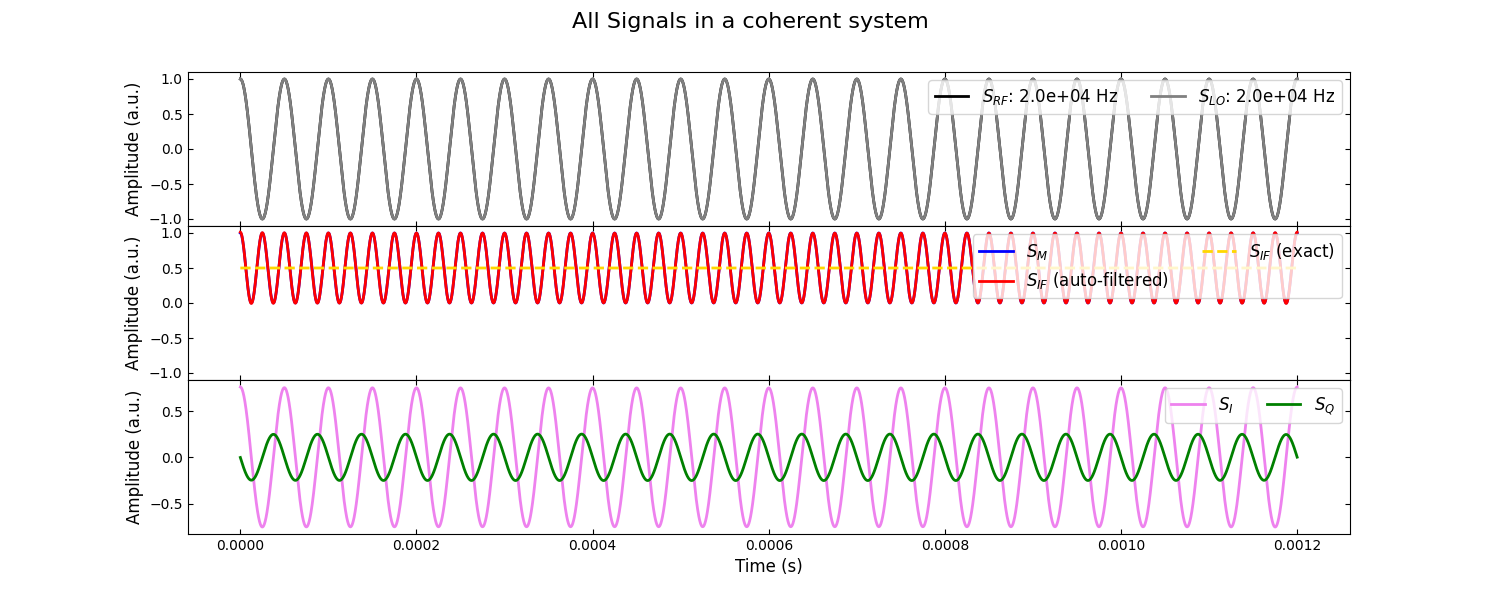

In [5]:


freq_rf = np.random.randint(20e3, 300e9)  # Hz
freq_rf = 20e3  # Hz
amplitude_rf = 1
amplitdue_lo = amplitude_rf
diff = 0.1
fs = 10001 # sampling frequency
def get_time_arr(fs: int):
    return np.linspace(0, 24/freq_rf, fs)

t = get_time_arr(fs)

signal_rf = harmonic_generator(freq=freq_rf, t=t, amplitude=amplitude_rf)
signal_lo = harmonic_generator(freq=freq_differ(freq_rf, diff), t=t, amplitude=amplitdue_lo)
signal_m = signal_rf * signal_lo
signal_if, *_ = fourier_low_pass(input_signal = signal_m, fs = fs)
signal_if_exact = harmonic_generator(freq=freq_rf - freq_differ(freq_rf, diff), t=t, amplitude=amplitude_rf * amplitdue_lo / 2)
signal_i, *_ = fourier_low_pass(input_signal = signal_if * harmonic_generator(freq=freq_differ(freq_rf, diff), t=t, amplitude=amplitdue_lo), fs = fs)
signal_q, *_ = fourier_low_pass(input_signal = signal_if * harmonic_generator(freq=freq_differ(freq_rf, diff), t=t, amplitude=amplitdue_lo, phase=np.pi/2), fs = fs)

fig = plt.figure(figsize=(15, 6))
fig.suptitle(r'All Signals in a coherent system', fontsize = 16)
gs = GridSpec(3, 1)

ax1 = fig.add_subplot(gs[0, 0])
ax1.tick_params(axis='both', which='both', direction = 'in', top=True, bottom=True, left=True, right=True)
l10, = ax1.plot(t, signal_rf, linewidth = 2, color = 'black', label = r'$S_{RF}$: ' + f'{(freq_rf):.1e} Hz')
l11, = ax1.plot(t, signal_lo, linewidth = 2, color = 'grey', label = r'$S_{LO}$: ' + f'{(freq_differ(freq_rf, diff)):.1e} Hz')

# ax1.set_xlabel(r'Time (s)', fontsize = 14)
ax1.set_ylabel(r'Amplitude (a.u.)', fontsize = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

ax2 = fig.add_subplot(gs[1, 0])
ax2.tick_params(axis='both', which='both', direction = 'in', top=True, bottom=True, left=True, right=True)
l21, = ax2.plot(t, signal_m, linewidth = 2, color = 'blue', label = r'$S_{M}$')
l22, = ax2.plot(t, signal_if, linewidth = 2, color = 'red', label = r'$S_{IF}$ (auto-filtered)')
l23, = ax2.plot(t, signal_if_exact, linewidth = 2, color = 'gold', linestyle = 'dashed', label = r'$S_{IF}$ (exact)')

# signal_if_fit_params = fitter(t, signal_if_exact, fit_func = harmonic_generator)
# signal_if_fit = harmonic_generator(freq=signal_if_fit_params['Frequency'], t=t, amplitude=signal_if_fit_params['Amplitude'], phase=signal_if_fit_params['Phase'], offset=signal_if_fit_params['Offset'])
# l24, = ax2.plot(t, signal_if_fit, linewidth = 2, color = 'darkred', linestyle = 'dotted', label = r'$S_{IF}$ (fit)')

# ax2.set_xlabel(r'Time (s)', fontsize = 14)
ax2.set_ylabel(r'Amplitude (a.u.)', fontsize = 12)

ax3 = fig.add_subplot(gs[2, 0])
ax3.tick_params(axis='both', which='both', direction = 'in', top=True, bottom=True, left=True, right=True)
l31, = ax3.plot(t, signal_i, linewidth = 2, color = 'violet', label = r'$S_{I}$')
l32, = ax3.plot(t, signal_q, linewidth = 2, color = 'green', label = r'$S_{Q}$')

ax3.set_xlabel(r'Time (s)', fontsize = 12)
ax3.set_ylabel(r'Amplitude (a.u.)', fontsize = 12)

plt.subplots_adjust(hspace=0.0)

slider_freq_diff = FloatSlider(value=0.000, min=0.00, max=1.00, step=0.01, description=r"$\Delta\nu$")

@interact(diff = slider_freq_diff)
def update_plot(diff):
    updated_signal_lo = harmonic_generator(freq=freq_differ(freq_rf, diff), t=t, amplitude=1)
    updated_signal_m = signal_rf * updated_signal_lo
    updated_signal_if, *_ = fourier_low_pass(input_signal = updated_signal_m, fs = fs)
    updated_signal_if_exact = harmonic_generator(freq=freq_rf - freq_differ(freq_rf, diff), t=t, amplitude=amplitude_rf * amplitdue_lo / 2)
    # try:
    #     updated_signal_if_fit_params = fitter(t, updated_signal_if, fit_func = harmonic_generator)
    #     updated_signal_if_fit = harmonic_generator(freq=updated_signal_if_fit_params['Frequency'], t=t, amplitude=updated_signal_if_fit_params['Amplitude'], phase=updated_signal_if_fit_params['Phase'], offset=updated_signal_if_fit_params['Offset'])
    #     l24.set_ydata(updated_signal_if_fit)
    #     l24.set_label(r'$S_{IF}$ (fit), $\nu_{IF}$ = ' + f'{(updated_signal_if_fit_params["Frequency"]):.2f} Hz')
    # except:
    #     l24.set_label(r'$S_{IF}$ (fit): ' + r'Fit failed')
    updated_signal_i, *_ = fourier_low_pass(input_signal=updated_signal_if * harmonic_generator(freq=freq_differ(freq_rf, diff), t=t, amplitude=amplitdue_lo), fs = fs)
    updated_signal_q, *_ = fourier_low_pass(input_signal=updated_signal_if * harmonic_generator(freq=freq_differ(freq_rf, diff), t=t, amplitude=amplitdue_lo, phase=np.pi/2), fs = fs)
    
    l11.set_ydata(updated_signal_lo)
    l11.set_label(r'$S_{LO}$: ' + f'{(freq_differ(freq_rf, diff)):.1e} Hz')

    l21.set_ydata(updated_signal_m)
    l22.set_ydata(updated_signal_if)
    l23.set_ydata(updated_signal_if_exact)
    

    l31.set_ydata(updated_signal_i)
    l32.set_ydata(updated_signal_q)
    # signal_baseband = updated_signal_i + 1j * updated_signal_q
    # amplitude = np.abs(signal_baseband)
    # phase = np.angle(signal_baseband)
    # # l31.set_label(r'$S_{I}$, $\left|S_{baseband}\right|$ = ' + f'{amplitude}')
    # # l32.set_label(r'$S_{Q}$, $\angle S_{baseband}$ = ' + f'{phase}')
    # print(f'Amplitude: {amplitude}')
    # print(f'Phase: {phase}')
    ax3.relim()

    ax1.legend(loc='upper right', fontsize=12, ncol=2)
    ax2.legend(loc='upper right', fontsize=12, ncol=2)
    ax3.legend(loc='upper right', fontsize=12, ncol=2)
    fig.canvas.draw_idle()
    # plt.tight_layout()
